# Import Data from Simulations

In [1]:
from itertools import product
betas = [0.01, 0.1, 0.2, 0.3]
xy = [(1, 10), (1, 4), (1, 2), (1, 1), (2, 1), (4, 1), (10, 1)]
prod_vars = [betas, xy]
combinations = list(product(*prod_vars))
#combinations=[(0.01, (1, 10))]

In [2]:
from pathlib import Path
import pickle
output_dir = '/home/nishka/nuplan-devkit/tutorials/Fixing LQR Simulation/sc15_gridsearch_data_Crisk'
simulation_files = [str(file) for file in Path(output_dir).rglob("*") if file.is_file()]

all_scenarios15 = {}
for fname, comb in zip(simulation_files, combinations):
    #print(comb)
    with open(fname, 'rb') as f:
        all_scenarios15[comb] = pickle.load(f)

# Methods to Compute Metrics - Frame Wise

In [3]:
from shapely import LineString
import math
import numpy as np

def compute_optimality(traj):
    # distance travelled
    return LineString(traj).length
    
def compute_safety(traj, neighbors):
    # distance to nearest neighbor
    from math import sqrt
    min_dist = 10e7
    for i in range(neighbors.shape[0]):
        for (ego_x, ego_y), (nx, ny) in zip(traj, neighbors[i]):
            cur_dist = sqrt((ego_x - nx)**2 + (ego_y - ny)**2)
            if cur_dist < min_dist:
                min_dist = cur_dist
    return min_dist
    
def compute_comfort(traj):
    # median acceleration
    t = 0.1 #s
    acc_mag = []
    for i in range(1, len(traj)-1):
        ax = (traj[i-1, 0] - 2 * traj[i, 0] + traj[i+1, 0]) / t**2
        ay = (traj[i-1, 1] - 2 * traj[i, 1] + traj[i+1, 1]) / t**2
        acc_mag.append(math.sqrt(ax ** 2 + ay ** 2))
        
    return np.percentile(acc_mag, 50)

def compute_metrics(inp):
    opt = compute_optimality(inp['traj'])
    safe = compute_safety(inp['traj'],
                          inp['data'].data['future_neighbor_pos'][0])
    comf = compute_comfort(inp['traj'])
    return opt, safe, comf

# Box Plots for Scenarios

In [19]:
import pandas as pd

dfkeys = ['beta', 'xy_par', 'frame', 'comfort', 'optimality', 'safety']
metrics = {}
for key in dfkeys:
    metrics[key] = []

num_frames = 120
for comb in combinations:
    beta, xy_par = comb
    for frame_id in range(num_frames):
        opt, safe, comf = compute_metrics(all_scenarios15[comb][frame_id])
        
        metrics['beta'].append(str(beta))
        metrics['xy_par'].append(xy_par)
        metrics['frame'].append(frame_id)
        
        metrics['comfort'].append(comf)
        metrics['optimality'].append(opt)
        metrics['safety'].append(safe)
metrics = pd.DataFrame(metrics)
#metrics

## betas boxplot

In [20]:
import seaborn as sns

<Axes: xlabel='comfort', ylabel='beta'>

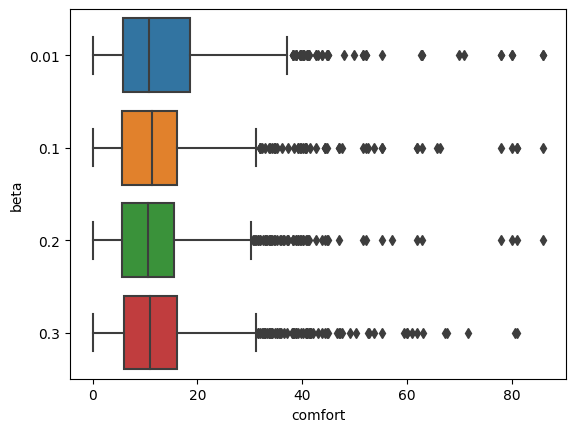

In [21]:
#for beta in betas:
sns.boxplot(data=metrics, x="comfort", y="beta")

<Axes: xlabel='optimality', ylabel='beta'>

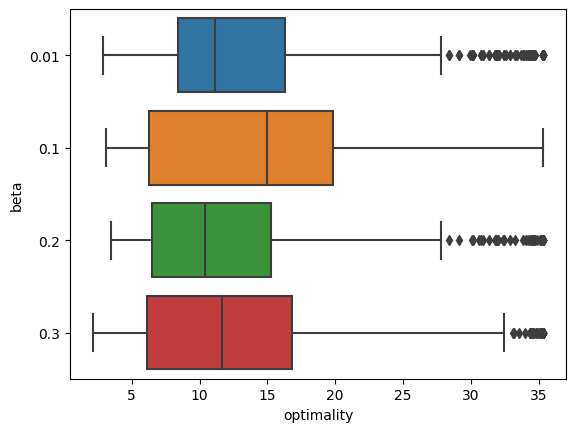

In [22]:
sns.boxplot(data=metrics, x="optimality", y="beta")

<Axes: xlabel='safety', ylabel='beta'>

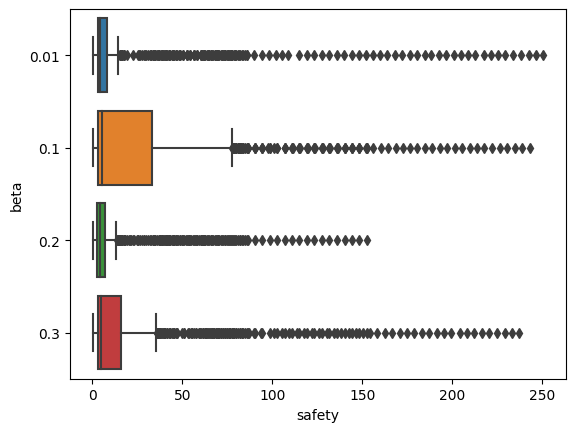

In [23]:
sns.boxplot(data=metrics, x="safety", y="beta")

## (x_param, y_param) box plots
where x_par and y_par are inputs to the  matrix for each

<Axes: xlabel='optimality', ylabel='xy_par'>

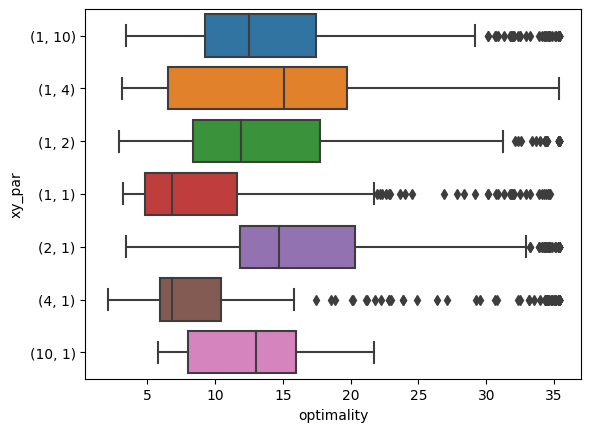

In [24]:
sns.boxplot(data=metrics, x="optimality", y="xy_par")

<Axes: xlabel='comfort', ylabel='xy_par'>

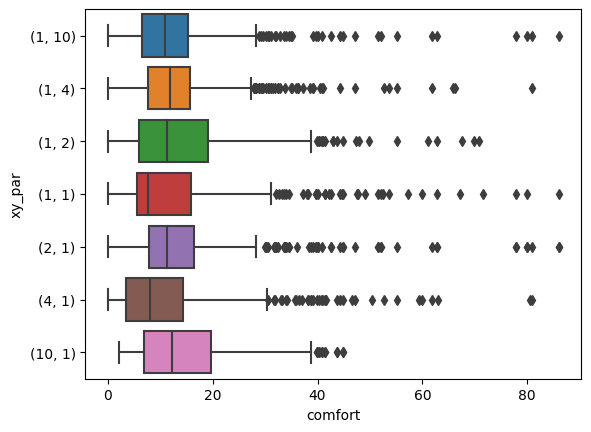

In [25]:
sns.boxplot(data=metrics, x="comfort", y="xy_par")

<Axes: xlabel='safety', ylabel='xy_par'>

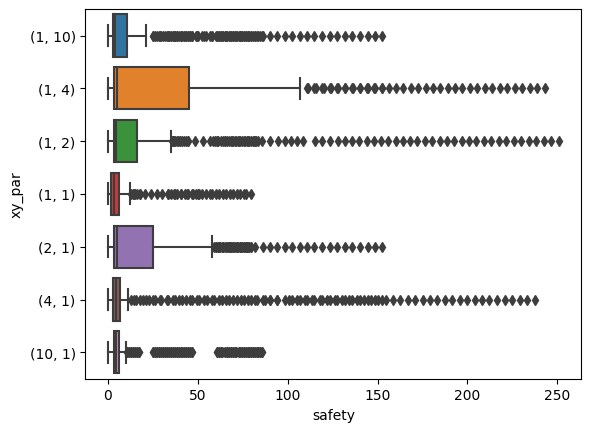

In [26]:
sns.boxplot(data=metrics, x="safety", y="xy_par")